In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import math
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy as dc

In [62]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [63]:
data = pd.read_csv("../data/weather.csv")
print(data.head())
print(data.info())
print(data.describe())

         Date  Rainfall amount (millimetres)  Maximum temperature (Degree C)
0  2013-06-02                            5.0                            15.7
1  2013-06-03                            0.2                            14.8
2  2013-06-04                            0.2                            15.0
3  2013-06-05                            0.0                            14.6
4  2013-06-06                            0.0                            17.3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            3922 non-null   object 
 1   Rainfall amount (millimetres)   3922 non-null   float64
 2   Maximum temperature (Degree C)  3922 non-null   float64
dtypes: float64(2), object(1)
memory usage: 92.1+ KB
None
       Rainfall amount (millimetres)  Maximum temperature (Degree C)


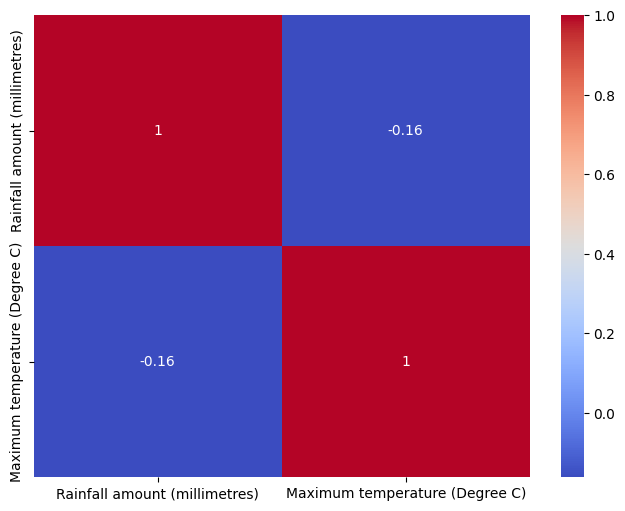

In [64]:
numeric_data = data.select_dtypes(include = ["int64", "float64"])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.show()

In [65]:
start_date = "1986-03-13" #@param {type:"date"}
end_date = "2024-01-01" #@param {type:"date"}

In [66]:
data['Date'] = pd.to_datetime(data['Date'])

data_date_filtered = data.loc[
    (data['Date'] > start_date) &
     (data['Date'] < end_date)
]
print(data_date_filtered)

           Date  Rainfall amount (millimetres)  Maximum temperature (Degree C)
0    2013-06-02                            5.0                            15.7
1    2013-06-03                            0.2                            14.8
2    2013-06-04                            0.2                            15.0
3    2013-06-05                            0.0                            14.6
4    2013-06-06                            0.0                            17.3
...         ...                            ...                             ...
3855 2023-12-27                            3.0                            24.0
3856 2023-12-28                            0.8                            20.8
3857 2023-12-29                            0.0                            20.4
3858 2023-12-30                            0.0                            19.0
3859 2023-12-31                            0.6                            20.8

[3860 rows x 3 columns]


In [67]:
max_temp = data_date_filtered.filter(["Maximum temperature (Degree C)"])
dataset = max_temp.values

In [68]:
percent_to_train = 95 #@param {type:"integer"}
training_data_len = int(np.ceil(len(dataset))*(percent_to_train/100))
print("Data to use for training: ", training_data_len)
print("Data to use for testing: ", (len(dataset) - training_data_len))

Data to use for training:  3667
Data to use for testing:  193


In [69]:
#@title Configure problem

n_timesteps_in = 40  #@param {type:"integer"}
#each input sample has 60 values

n_features = 1   #@param {type:"integer"}
#each value is one number

In [70]:
def create_dataset(dataset, n_timesteps_in, n_features):
  X, Y = [], []
  for i in range(n_timesteps_in, len(dataset)-10):
    X.append(dataset[i-n_timesteps_in:i, 0])
    Y.append(dataset[i:i+10,0])
  X, Y = np.array(X), np.array(Y)
  X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
  Y = np.reshape(Y, (Y.shape[0], Y.shape[1], 1))
  return torch.tensor(X).float(), torch.tensor(Y).float()

In [71]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len]
X_train, Y_train = create_dataset(training_data, n_timesteps_in, n_features)

print(X_train.shape)

print(Y_train.shape)

torch.Size([3617, 40, 1])
torch.Size([3617, 10, 1])


In [72]:
test_data = scaled_data[(training_data_len - n_timesteps_in):]

X_test, Y_test = create_dataset(test_data, n_timesteps_in, n_features)

print(X_test.shape)
print(Y_test.shape)

torch.Size([183, 40, 1])
torch.Size([183, 10, 1])


In [73]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset = TimeSeriesDataset(X_test, Y_test)

In [74]:
epochs = 20 #@param {type:"integer"}
total_samples = X_train.shape[0]
batch_size = 32 #@param {type:"integer"}
steps_num = math.ceil(total_samples/batch_size)
print("Steps: ", steps_num)

Steps:  114


In [75]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [76]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([32, 40, 1]) torch.Size([32, 10, 1])


In [77]:
class Encoder(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    # Takes 1 time series value in this example, to hidden size
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(1, hidden_size, batch_first = True)

  def forward(self, encoder_inputs):
    # inputs: (batch size, input seq len, num enc features)
    batch_size = encoder_inputs.size(0)
    outputs, hidden = self.rnn(encoder_inputs)
    # output: (batch size, input seq len, hidden size)
    # hidden: (num rnn layers, batch size, hidden size)
    return outputs, hidden

In [78]:
class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Also takes 1 time series value
        self.rnn = nn.RNNCell(1, hidden_size)
        # The output layer transforms the latent representation
        # back to a single prediction
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, initial_input, hidden, targets,
                teacher_force_probability):
        # NOTE:
        # initial_input is X_t
        # hidden is Z
        # targets looks like: [X_t+1, X_t+2, X_t+3, ...]
        # encoder_outputs are not used, but will be for attention later
        batch_size = initial_input.shape[0]
        decoder_sequence_length = targets.shape[1]

        # Store decoder outputs
        outputs = torch.zeros(batch_size, decoder_sequence_length, 1).to(device)
        input_at_t = initial_input

        # Here we have to roll out the decoder sequence ourselves because of
        # sometimes teacher forcing
        for t in range(decoder_sequence_length):
            hidden = self.rnn(input_at_t, hidden)
            output = self.out(hidden)
            # Set-up input for next timestep
            outputs[:,t,:] = output
            teacher_force = random.random() < teacher_force_probability
            # The next timestep's input will either be this timestep's
            # target or output
            input_at_t = targets[:,t,:] if teacher_force else output
        return outputs

In [79]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, lr):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.optimizer = torch.optim.Adam(self.parameters(), lr)
        # The best loss function to use depends on the problem.
        # We will see a different loss function later for probabilistic
        # forecasting
        self.loss_function = nn.L1Loss()

    def forward(self, encoder_inputs, targets, teacher_force_probability):
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        outputs = self.decoder(encoder_inputs[:,-1,:], hidden[0], targets, teacher_force_probability)
        return outputs

    def compute_loss(self, outputs, targets):
        loss = self.loss_function(outputs, targets)
        return loss

    def optimize(self, outputs, targets):
        self.optimizer.zero_grad()
        loss = self.compute_loss(outputs, targets)
        loss.backward()
        self.optimizer.step()

In [80]:
learning_rate = 0.001
hidden_size = 200
model = Seq2Seq(Encoder(hidden_size), Decoder(hidden_size), learning_rate)
model.to(device)


print(model)

Seq2Seq(
  (encoder): Encoder(
    (rnn): RNN(1, 200, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): RNNCell(1, 200)
    (out): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss_function): L1Loss()
)


In [81]:
def train_one_epoch(model, train_loader, device):
  model.train(True)
  print(f'Epoch {epoch +1}')
  running_loss = 0.0

  for batch_indx, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    output = model(x_batch, y_batch, 0.75)
    loss = model.compute_loss(output, y_batch)
    model.optimize(output, y_batch)

    running_loss += loss
    if batch_indx % 100 == 99:
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss {1:.3f}'.format(batch_indx+1, avg_loss_across_batches))
      running_loss = 0.0

  print()

In [82]:
def validate_one_epoch(model, test_loader, device):
  model.train(False)
  running_loss = 0.0

  for batch_indx, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch, y_batch, 0.25)
      loss = model.compute_loss(output, y_batch)
      running_loss += loss

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()


In [ ]:
for epoch in range(epochs):
  train_one_epoch(model, train_loader, device)
  validate_one_epoch(model, test_loader, device)

Epoch 1


(36170,)


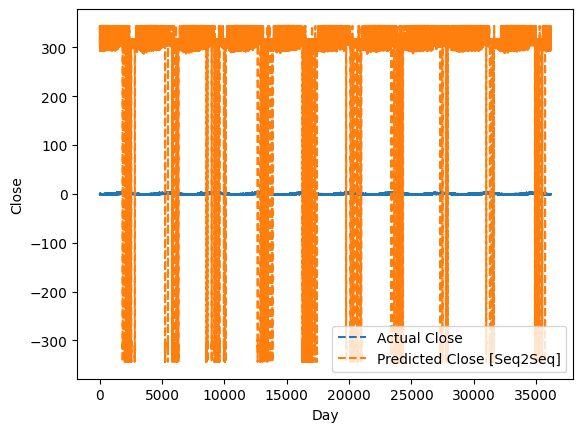

In [ ]:
with torch.no_grad():
  predicted = model(X_train.to(device), Y_train.to(device), 0.25).to('cpu').numpy().flatten()

train_data = Y_train.numpy().flatten()
print(predicted.shape)
plt.plot(train_data, ls='--', label='Actual Close')
plt.plot(predicted, ls='--', label='Predicted Close [Seq2Seq]')

plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
dummies = np.zeros((predicted.shape[0], 100+1))
dummies[:, 0] = predicted
dummies = scaler.inverse_transform(dummies)

predicted = dc(dummies[:, 0])
predicted

array([2088.62885843, 1863.02403782, 1924.47439274, ..., 1802.15594902,
       1788.79794989, 1925.12343417], shape=(36170,))

In [ ]:
dummies = np.zeros((predicted.shape[0], 100+1))
dummies[:, 0] = Y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([17.30000001, 15.40000017, 16.30000011, ..., 14.60000018,
       11.89999999, 12.09999989], shape=(36170,))

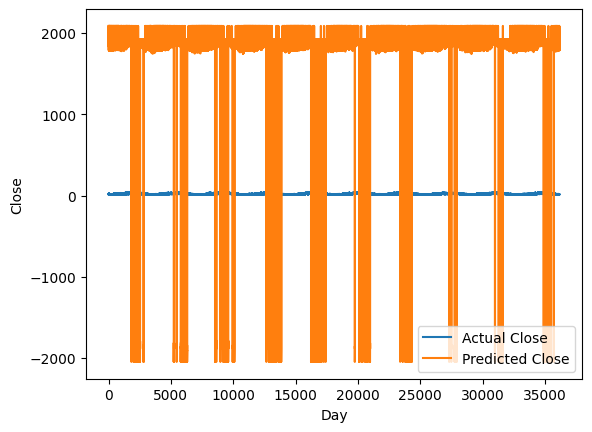

In [ ]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

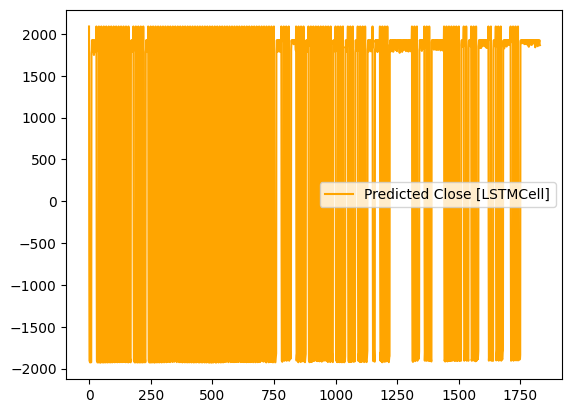

In [ ]:
with torch.no_grad():
  test_predictions = model(X_test.to(device), Y_test.to(device), 0.75).detach().cpu().numpy().flatten()


dummies = np.zeros((test_predictions.shape[0], 100+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])


plt.plot(test_predictions, label='Predicted Close [LSTMCell]', color='orange')
plt.legend()
plt.show()

In [ ]:
dummies = np.zeros((test_predictions.shape[0], 100+1))
dummies[:, 0] = Y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

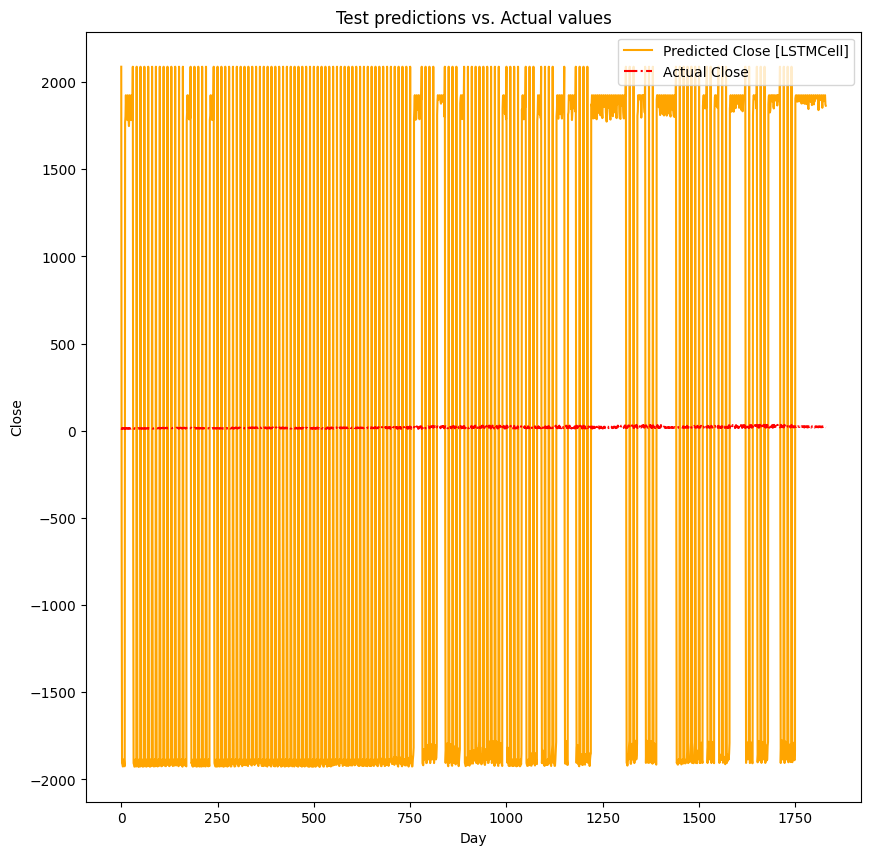

In [ ]:
test_graph = plt.subplots(1,1, figsize=(10,10))[1]
test_graph.plot(test_predictions, label='Predicted Close [LSTMCell]', color='orange', ls='-')
test_graph.plot(new_y_test, label='Actual Close', color='red', ls='dashdot')
test_graph.set_title('Test predictions vs. Actual values')
test_graph.set_xlabel('Day')
test_graph.set_ylabel('Close')
plt.legend()
plt.savefig('StockLSTM.png')
plt.show()
#files.download("StockLSTM.png")